# Cassava Leaf Disease Classification
Details: [kaggle.com](https://www.kaggle.com/c/cassava-leaf-disease-classification)

#### Usefull functions:

In [1]:
import zipfile
import shutil, pathlib
from tqdm.auto import tqdm

def create_path(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def remove_path(path):
  shutil.rmtree(path, ignore_errors=True)

def recreate_path(path):
  remove_path(path)
  create_path(path)

def unzip_file(filename, target_path='.'):
  create_path(target_path)
  zf = zipfile.ZipFile(filename, 'r')
  zf.extractall(target_path)
  zf.close()

def unzip_files(filename_list, target_path='.'):
  for filename in tqdm(zip_files):
    unzip_file(filename, target_path)

def get_size(root = '.'):
  total_size = 0
  for dirpath, _, filenames in os.walk(root):
      for f in filenames:
          fp = os.path.join(dirpath, f)
          total_size += (os.path.getsize(fp) if os.path.isfile(fp) else 0)
  return total_size

## Prepare kaggle dataset

In [2]:
!pip install -q kaggle
!mkdir -p  ~/.kaggle
!wget -qO ~/.kaggle/kaggle.json https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/Project/kaggle/key/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [3]:
!mkdir -p Dataset
!kaggle competitions download -c cassava-leaf-disease-classification --path Dataset

1003442061.jpg: Skipping, found more recently modified local copy (use --force to force download)
1000201771.jpg: Skipping, found more recently modified local copy (use --force to force download)
1002394761.jpg: Skipping, found more recently modified local copy (use --force to force download)
1001749118.jpg: Skipping, found more recently modified local copy (use --force to force download)
1003218714.jpg: Skipping, found more recently modified local copy (use --force to force download)
1003888281.jpg: Skipping, found more recently modified local copy (use --force to force download)
1003298598.jpg: Skipping, found more recently modified local copy (use --force to force download)
1001320321.jpg: Skipping, found more recently modified local copy (use --force to force download)
1003987001.jpg: Skipping, found more recently modified local copy (use --force to force download)
1001723730.jpg: Skipping, found more recently modified local copy (use --force to force download)
1001742395.jpg: Skip

In [4]:
from glob import glob
data_path = "Dataset/"
zip_files = glob(data_path+'*.zip')
unzip_files(zip_files, target_path=data_path+'train_tfrecords')

## Preprocessing

#### Analysis the labels

In [5]:
import os
import pandas as pd

data_path = "Dataset/" #"/kaggle/input/cassava-leaf-disease-classification/"
train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import tensorflow as tf


label_encoder = LabelEncoder()
label_encoder.fit(label_class)
func_num_or_list = lambda func, x: func(x) if isinstance(x, (list,np.ndarray,tf.Tensor)) else func([x])[0] 
label_encode = lambda arr_str: func_num_or_list(label_encoder.transform,arr_str)
label_decode = lambda arr: func_num_or_list(label_encoder.inverse_transform,arr)

label_onehotEncoder = OneHotEncoder()
label_onehotEncoder.fit(np.arange(5).reshape(-1,1))
def onehot_decode(arr):
  np_arr = arr.numpy() if isinstance(arr, tf.Tensor) else np.array(arr)
  if len(np_arr.shape) is 1: np_arr = np_arr.reshape(1,-1)
  return label_onehotEncoder.inverse_transform(np_arr).squeeze() 
label_name = lambda arr: label_decode(onehot_decode(arr).tolist()).tolist()
num_classes = len(label_class)

pd.DataFrame(label_encoder.classes_, columns=['Label names'])

,Label names
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [7]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


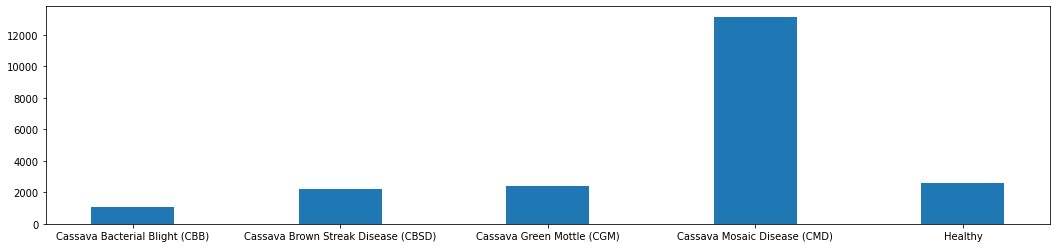

21397


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tags = label_decode(np.arange(5))
all_labels = np.array(list(map(int, train_csv.iloc[:,1])))

def plot_hist_labels(all_labels):
  fig, ax = plt.subplots()
  all_labels_counts, _, _= plt.hist(all_labels, bins=np.arange(-0.5,5.5), rwidth=0.4)
  plt.xticks(np.arange(5))
  ax.set_xticklabels(tags)
  fig.set_size_inches(18,4)
  plt.show()
  return all_labels_counts

all_labels_counts = plot_hist_labels(all_labels)
num_all_labels = len(all_labels)
print(num_all_labels)

In [9]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


#### Load Images

Extract images:

In [10]:
from functools import partial
import tensorflow as tf
import os, pathlib, shutil
from tqdm.auto import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [512, 512]
DEFAULT_FUNC = lambda n:n
TRAIN_TFRECORDS_PATH = os.path.join(data_path, 'train_tfrecords')

def decode_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, image_size)
    return image

def read_tfrecord(example, labeled=True, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, load_filename=False):
    tfrecord_format = (
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = image_transform(decode_image(example["image"], image_size))
    ret = (image,)
    if load_filename:
        filename = example['image_name']
        ret +=(filename,)
    if labeled:
        label = label_transform(tf.cast(example["target"], tf.int32))
        ret +=(label,)
    return ret

def load_dataset(filenames, labeled, image_size, label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, disable_order=True, load_filename=False):
    ignore_order = tf.data.Options()
    if disable_order: ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, load_filename=load_filename), 
        num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, batch_size=BATCH_SIZE, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, reshuffle_each_iteration=None, disable_order=True, load_filename=False):
    dataset = load_dataset(filenames, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, disable_order=disable_order, load_filename=load_filename)
    if reshuffle_each_iteration: dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

def extract_dataset(filenames, save_dir='.', batch_size=BATCH_SIZE, labeled=True, image_size=[*IMAGE_SIZE,3], flush_path=True, num_samples=None):
    if flush_path: shutil.rmtree(save_dir, ignore_errors=True)
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

    dataset = get_dataset(filenames, image_size=image_size, labeled=labeled, load_filename=True, disable_order=False, reshuffle_each_iteration=False)
    if num_samples is None:
      print('Computing the number of samples:', end=' ')
      num_samples = tf.reduce_sum([y.shape for _,y,_ in dataset]) if labeled else tf.reduce_sum([y.shape for _,y in dataset])
      print(num_samples.numpy(), 'samples')

    images_path = []
    if labeled: label_list = []
    num_iter = tf.math.ceil(num_samples/32)
    iterator = iter(dataset)
    for _ in tqdm(tf.range(num_iter)):
      item = next(iterator)
      images, image_names = item[:2]
      if labeled:  labels = item[2].numpy()
      for i in tf.range(image_names.shape):
        image_path = os.path.join(save_dir, image_names[i].numpy().decode("utf-8"))
        tf.keras.preprocessing.image.save_img(image_path, images[i])

        if labeled: label_list.append(labels[i])
        images_path.append(image_path)
    del dataset, iterator

    if labeled:
      return np.array(images_path), np.array(label_list)
    else:
      return np.array(images_path)


import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7, 7))
    plt.tight_layout()
    plt.subplots_adjust(right=2., top=2.)
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(label_decode(label_batch[n]), fontsize=10)
        plt.axis("off")
    plt.show()

In [11]:
FILENAMES = tf.io.gfile.glob(os.path.join(TRAIN_TFRECORDS_PATH,"ld_train*.tfrec"))
TRAIN_IMAGES_PATH = os.path.join(data_path,'train_images')
if not os.path.exists('IMAGES_INFO.npz'):
  ALL_IMAGES_PATH, ALL_LABELS = extract_dataset(FILENAMES, TRAIN_IMAGES_PATH, num_samples=num_all_labels, flush_path=True, batch_size=1024)
  np.savez_compressed('IMAGES_INFO.npz', filenames=ALL_IMAGES_PATH, labels=ALL_LABELS)
else:
  print('"%s" is already existed!'%TRAIN_IMAGES_PATH)
  images_info = np.load('IMAGES_INFO.npz', allow_pickle=True)
  ALL_IMAGES_PATH, ALL_LABELS = images_info['filenames'], images_info['labels']
print('the size of "%s" is %0.3f (Gbyte)'%(TRAIN_IMAGES_PATH, get_size(TRAIN_IMAGES_PATH)/2**30))

"Dataset/train_images" is already existed!
the size of "Dataset/train_images" is 1.291 (Gbyte)


In [12]:
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(all_labels),all_labels)
class_weights = np.sum(all_labels_counts)/all_labels_counts/num_classes
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 3.936890524379025,
 1: 1.954956601187757,
 2: 1.7935456831517183,
 3: 0.32523179814561487,
 4: 1.660613116026387}

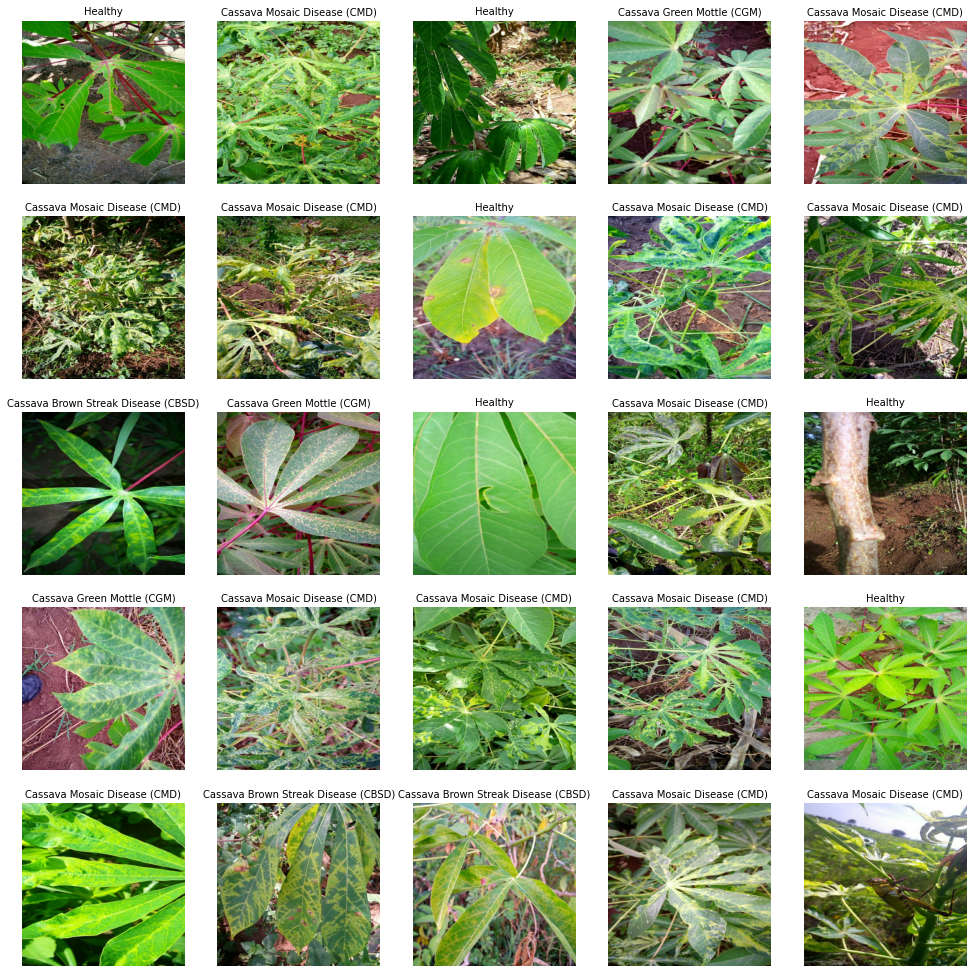

In [13]:
sample_dataset = get_dataset([os.path.join(data_path,"train_tfrecords","ld_train15-1327.tfrec")])
image_batch, label_batch = next(iter(sample_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
def w_noise(img, VARIABILITY=10):
    '''Add random noise to an image'''
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape).astype(np.uint8)
    image = img+noise
    np.clip(image, 0, 255)
    return image

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros_like(image)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def add_noise(img):
  max_prob = 0.05
  var = 15
  r = np.random.random()
  if r > 0.5:
    out = sp_noise(img, r*max_prob)
  else:
    out = w_noise(img, r*var)
  return out

In [15]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

validation_split = 0.15
batch_size = 128
image_size = [320, 320]

augmentaion_info = dict(rotation_range=360,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        brightness_range=[0.1,0.9],
                        shear_range=25,
                        zoom_range=0.3,
                        channel_shift_range=0.1,
                        horizontal_flip=True,
                        vertical_flip=True,
#                         preprocessing_function=add_noise
                        )

train_gen = ImageDataGenerator( rescale=1/255., validation_split=validation_split, **augmentaion_info)
valid_gen = ImageDataGenerator( rescale=1/255., validation_split=validation_split)

train_generator = train_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = image_size,
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "training",

)

valid_generator = valid_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = image_size,
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            subset = "validation"
)
                          

Found 18188 validated image filenames belonging to 5 classes.
Found 3209 validated image filenames belonging to 5 classes.


In [16]:
import tensorflow as tf

FILENAMES = tf.io.gfile.glob(data_path+"train_tfrecords/ld_train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TEST_FILENAMES = tf.io.gfile.glob(data_path + "test_tfrecords/ld_test*.tfrec")
print("Train TFRecord Files:    ", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:      ", len(TEST_FILENAMES))

num_classes = len(label_class)
batch_size = 32
image_size = [320,320]
label_transform = lambda x: tf.one_hot(x, depth=num_classes)
image_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255), 
    tf.keras.layers.experimental.preprocessing.Resizing(400, 400)])
def image_rescale(img):
    return tf.image.random_crop(img, size=[*image_size,3])/255.
    
def image_transform(img):
    im = image_rescale(img)
    im = tf.image.random_brightness(im, 0.15)
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_flip_up_down(im)
    im = tf.image.random_contrast(im, lower=0.8, upper=1.)
    im = tf.clip_by_value(im, 0., 1.)
    return im


train_dataset = get_dataset(TRAINING_FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
valid_dataset = get_dataset(VALID_FILENAMES, label_transform=label_transform, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False)
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False)

Train TFRecord Files:     14
Validation TFRecord Files: 2
Test TFRecord Files:       0


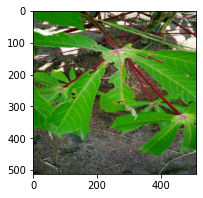

In [17]:
# Add the image to a batch
image = image_batch[0]

plt.figure(figsize=(3, 3))
plt.imshow(image/255)
# plt.axis("off")
plt.show()

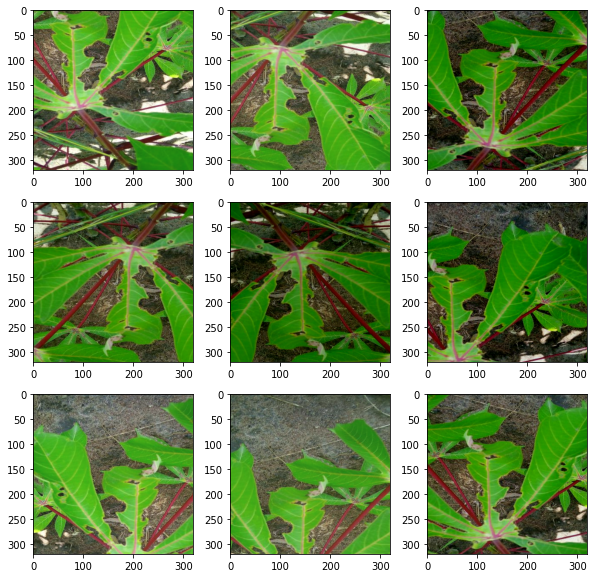

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = image_transform(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
#   plt.axis("off")
plt.show()

## Train

In [19]:
import tensorflow as tf


input = tf.keras.layers.Input(shape=(*image_size,3), name='input')
# model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)
model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)

avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model_base(input))
hidden_dense1 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense1',
                                      kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.005),
                                      bias_regularizer  =tf.keras.regularizers.L1L2(l1=0.01,l2=0.005))(avg_pool)
dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden_dense1)
hidden_dense2 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense2',
                                      kernel_regularizer=tf.keras.regularizers.L1(0.001), 
                                      bias_regularizer  =tf.keras.regularizers.L1(0.001))(dropout)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(hidden_dense2)
model = tf.keras.models.Model(inputs=input, outputs=output, name='Model')


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model6.h5", save_best_only=True, monitor='val_accuracy', mode='max')

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0), 
              metrics=['accuracy', 'categorical_accuracy'])

# tf.keras.utils.plot_model(model, to_file='model6.png', show_shapes=True)

In [20]:
for layer in model_base.layers[:]: layer.trainable = False
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1024)              0         
_________________________________________________________________
hidden_dense1 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_dense2 (Dense)        (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 5)                 2565  

In [ ]:
# history1 = model.fit(
#       train_generator,
#       steps_per_epoch=train_generator.samples // train_generator.batch_size,
#       epochs=2,
#       validation_data=valid_generator,
#       validation_steps = valid_generator.samples // valid_generator.batch_size,
#       batch_size= train_generator.batch_size,
#       callbacks = [checkpoint_cb]
#       )
history1 = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)

Epoch 1/5
      6/Unknown - 306s 49s/step - loss: 177.7501 - accuracy: 0.4212 - categorical_accuracy: 0.4212

In [ ]:
for layer in model_base.layers[:7]: layer.trainable = True
model.summary()

In [ ]:
history2 = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)
model.save('model6.h5')

In [ ]:
import matplotlib.pyplot as plt

history = {key:(history1.history[key]+history2.history[key]) for key in history1.history.keys()}

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history['loss'], marker='o', linestyle='solid', label='Train loss')
plt.plot(history['val_loss'], marker='o', linestyle='dashed', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history['categorical_accuracy'], marker='o', linestyle='solid', label='Train accuracy')
plt.plot(history['val_categorical_accuracy'], marker='o', linestyle='dashed', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('model6-history.png')
plt.show()


## TEST

In [ ]:
import tensorflow as tf
best_model = tf.keras.models.load_model("best_model6.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

y_true = valid_generator.classes
y_true_vec = tf.one_hot(y_true, num_classes)
y_pred_vec = best_model.predict(valid_generator, valid_generator.batch_size)
y_pred = np.argmax(y_pred_vec, axis=1)

categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()(y_pred=y_pred_vec, y_true=y_true_vec).numpy()
print('Accuracy with "valid_generator": %0.4f'%categorical_accuracy)

loss, accuracy, f1_score = best_model.evaluate(valid_dataset, verbose=0)
print('Accuracy with "valid_dataset": %0.4f'%accuracy)

## Results

In [ ]:
print('Confusion matrix, without normalization')
cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm)

In [ ]:
print('Normalized confusion matrix')
cm_p = cm / cm.astype(np.float).sum(axis=1)
pd.DataFrame(cm_p)

In [ ]:
target_names = list(train_generator.class_indices.keys()) # Classes
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, Title='Confusion Matrix'):
    tags = label_decode(np.arange(5))
    plt.figure(figsize=(8,6))
    fmt ='d' if cm.dtype == int else '.2f'
    sns.heatmap(cm,xticklabels=tags, yticklabels=tags, annot=True, fmt=fmt, cmap="Blues", vmin = 0.2);
    plt.title(Title)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, Title='Confusion matrix, without normalization')

In [ ]:
cm_p = cm / cm.astype(np.float).sum(axis=1)
plot_confusion_matrix(cm_p, Title='Normalized confusion matrix')

In [ ]:
import cv2
test_img_path = data_path+"test_images/2216849948.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, tuple(image_size)).reshape(-1, *image_size, 3)/255.

prediction = best_model.predict(resized_img)
plt.figure(figsize=(8,4))
plt.title(f'[{onehot_decode(prediction)}] {label_name(prediction)}')
plt.imshow(resized_img[0])
plt.show()

In [ ]:
preds = []
ss = pd.read_csv(data_path+'sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img(data_path+'test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, tuple(image_size))
    img = tf.reshape(img, (-1, *image_size, 3))
    prediction = best_model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False) 
my_submission